Root Mean Squared Error (RMSE): 152.28
R² Score: 0.973


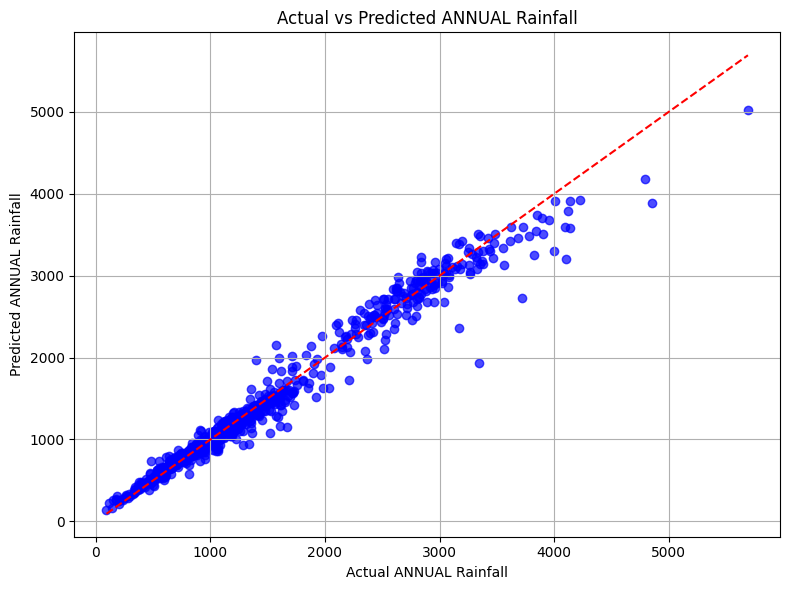

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/sample_data/Sub_Division_IMD_2017.csv')

# Select monthly rainfall as features and ANNUAL rainfall as target
features = df[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
               'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]
target = df['ANNUAL']

# Drop rows with missing values (if any)
features = features.dropna()
target = target[features.index]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# Optional: Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ANNUAL Rainfall')
plt.ylabel('Predicted ANNUAL Rainfall')
plt.title('Actual vs Predicted ANNUAL Rainfall')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load and sort dataset
df = pd.read_csv("/content/sample_data/Sub_Division_IMD_2017.csv")
df = df.sort_values(by=["SUBDIVISION", "YEAR"]).reset_index(drop=True)

# Prepare data: 5 years of ANNUAL rainfall → predict next year's ANNUAL
X, y = [], []

for subdivision in df['SUBDIVISION'].unique():
    sub_df = df[df['SUBDIVISION'] == subdivision].reset_index(drop=True)
    annual_rain = sub_df['ANNUAL'].values

    for i in range(len(annual_rain) - 5):
        if not np.isnan(annual_rain[i:i+6]).any():
            X.append(annual_rain[i:i+5])  # 5 years input
            y.append(annual_rain[i+5])    # 6th year output

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

# === USER INPUT ===
print("\nEnter ANNUAL rainfall data for the last 5 years:")
user_input = []
for i in range(1, 6):
    while True:
        try:
            val = float(input(f"Year {i}: "))
            user_input.append(val)
            break
        except ValueError:
            print("Please enter a valid number.")

user_array = np.array(user_input).reshape(1, -1)
prediction = model.predict(user_array)
print(f"\n🔮 Predicted ANNUAL Rainfall for next year: {prediction[0]:.2f} mm")


RMSE: 279.88
R² Score: 0.895

Enter ANNUAL rainfall data for the last 5 years:
Year 1: 640.5
Year 2: 512
Year 3: 391.4
Year 4: 461.2
Year 5: 305.5

🔮 Predicted ANNUAL Rainfall for next year: 463.45 mm


In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load and preprocess the dataset
df = pd.read_csv("/content/sample_data/Sub_Division_IMD_2017.csv")
df = df.sort_values(by=["SUBDIVISION", "YEAR"]).reset_index(drop=True)

# Encode location (SUBDIVISION)
le = LabelEncoder()
df['SUB_ENCODED'] = le.fit_transform(df['SUBDIVISION'])

# Prepare dataset: [location_code, annual1, annual2, ..., annual5] → annual6
X, y = [],[]

for subdivision in df['SUBDIVISION'].unique():
    sub_df = df[df['SUBDIVISION'] == subdivision].reset_index(drop=True)
    sub_code = le.transform([subdivision])[0]
    annual_series = sub_df['ANNUAL'].values

    for i in range(len(annual_series) - 5):
        if not np.isnan(annual_series[i:i+6]).any():
            X.append([sub_code] + annual_series[i:i+5].tolist())
            y.append(annual_series[i+5])

X = np.array(X)
y = np.array(y)

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

# Save the model and encoder
joblib.dump(model, 'model.pkl')
joblib.dump(le, 'encoder.pkl')

# === USER INPUT ===
print("\nAvailable locations:")
print(", ".join(sorted(df['SUBDIVISION'].unique())))

while True:
    location = input("\nEnter location (exact match from list): ").strip()
    if location in df['SUBDIVISION'].unique():
        break
    else:
        print("Invalid location. Please enter exactly as shown.")

user_rain = []
print(f"\nEnter ANNUAL rainfall for the last 5 years in {location}:")
for i in range(1, 6):
    while True:
        try:
            val = float(input(f"Year {i}: "))
            user_rain.append(val)
            break
        except ValueError:
            print("Please enter a valid number.")

# Prepare and predict
location_code = le.transform([location])[0]
user_features = np.array([location_code] + user_rain).reshape(1, -1)
predicted_rainfall = model.predict(user_features)

print(f"\n Predicted ANNUAL Rainfall for next year in {location}: {predicted_rainfall[0]:.2f} mm")


RMSE: 284.95
R² Score: 0.891

Available locations:
Andaman & Nicobar Islands, Arunachal Pradesh, Assam & Meghalaya, Bihar, Chhattisgarh, Coastal Andhra Pradesh, Coastal Karnataka, East Madhya Pradesh, East Rajasthan, East Uttar Pradesh, Gangetic West Bengal, Gujarat Region, Haryana Delhi & Chandigarh, Himachal Pradesh, Jammu & Kashmir, Jharkhand, Kerala, Konkan & Goa, Lakshadweep, Madhya Maharashtra, Matathwada, Naga Mani Mizo Tripura, North Interior Karnataka, Orissa, Punjab, Rayalseema, Saurashtra & Kutch, South Interior Karnataka, Sub Himalayan West Bengal & Sikkim, Tamil Nadu, Telangana, Uttarakhand, Vidarbha, West Madhya Pradesh, West Rajasthan, West Uttar Pradesh

Enter location (exact match from list): Bihar

Enter ANNUAL rainfall for the last 5 years in Bihar:
Year 1: 3432
Year 2: 122
Year 3: 1234
Year 4: 2345
Year 5: 4567

 Predicted ANNUAL Rainfall for next year in Bihar: 2752.99 mm
